In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import sys

import matplotlib.pyplot as plt

import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [7]:
# Create input matrix
x = torch.rand(10, 50)
W1 = nn.Parameter(torch.rand(128, 50))

# Let's see what W1 is
print("W1: ", W1)
print('\n\n')

# Its size and the size of its transpose
print(W1.shape)
print(W1.t().shape)
print('\n\n')

# compute an output
y = x@W1.t()
print(y.shape)

W1:  Parameter containing:
tensor([[0.0161, 0.7096, 0.0433,  ..., 0.9262, 0.5855, 0.0548],
        [0.6331, 0.1260, 0.6183,  ..., 0.3255, 0.8295, 0.3883],
        [0.1915, 0.7793, 0.2995,  ..., 0.1512, 0.1433, 0.7554],
        ...,
        [0.7483, 0.4784, 0.7876,  ..., 0.8694, 0.9239, 0.4321],
        [0.8037, 0.6995, 0.0942,  ..., 0.0656, 0.0370, 0.1956],
        [0.2197, 0.0178, 0.6179,  ..., 0.0504, 0.7625, 0.0594]],
       device='cuda:0', requires_grad=True)



torch.Size([128, 50])
torch.Size([50, 128])



torch.Size([10, 128])


In [13]:
# Now try again with the Linear method
W2 = nn.Linear(128, 50)

# Let's see what W2 is
print(W2)
print("\n\n")

# Its size and the size of its transpose
print(W2.weight.shape)
print(W2.weight.t().shape)
print('\n\n')

# compute an output
print(x.shape, W2.weight.shape)
y = x @ (W2.weight)
print(y.shape)

Linear(in_features=128, out_features=50, bias=True)



torch.Size([50, 128])
torch.Size([128, 50])



torch.Size([10, 50]) torch.Size([50, 128])
torch.Size([10, 128])


In [12]:
# confusion from the previous cells
print(W1.shape)
print(W2.weight.shape)

# confusion solved ;)
# (size of W -> [outputs,inputs], but nn.Linear expects [inputs,outputs])

torch.Size([128, 50])
torch.Size([50, 128])


In [18]:
# see all attributes of the class Linear
dir(nn.Linear)

# and the docstring for Linear.forward
# ??nn.Linear.forward()
# ??nn.Linear.__init__() # note the inputs vs. how weight is created

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_compiled_call_impl',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 '_wrapped_call_impl',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'call_super_init',
 'children',
 'compile',
 'cpu',
 'cuda',
 'double',
 'dump_p

In [19]:
# import dataset (comes with colab!)
data = np.loadtxt(open("../Datasets/mnist_train_small.csv", "rb"), delimiter=",")

# don't need labels!
data = data[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor(dataNorm).float()

In [20]:
# create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 128)

            ### encoder layer
            self.enc = nn.Parameter(torch.randn(50, 128))
            # self.enc = nn.Linear(128,50) # not used! left here for comparison

            ### latent layer (not used!)
            # self.lat = nn.Linear(50,128)

            ### decoder layer
            self.dec = nn.Linear(128, 784)

        # forward pass
        def forward(self, x):
            # "normal" forward prop in first stage
            x = F.relu(self.input(x))

            # a Parameter type is not a Linear type, so we implement the multiplication directly
            x = (
                x.t()
            )  # need to transpose the input matrix due to multisample input matrices
            x = F.relu(self.enc @ x)

            # same for the decoding layer but reversed
            x = F.relu(self.enc.t() @ x)
            x = x.t()  # and then transpose it back

            # "normal" final stage
            y = torch.sigmoid(self.dec(x))
            return y

    # create the model instance
    net = aenet()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [21]:
# test the model with a bit of data
net, lossfun, optimizer = createTheMNISTAE()

X = dataT[:5, :]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


In [24]:
# Function to train the model
def function2trainTheModel():

    # number of epochs
    numepochs = 10000

    # create a new model
    net, lossfun, optimizer = createTheMNISTAE()

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # select a random set of images
        randomidx = np.random.choice(dataT.shape[0], size=32)
        X = dataT[randomidx, :]

        # forward pass and loss
        yHat = net(X)
        loss = lossfun(yHat, X)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # losses in this epoch
        losses[epochi] = loss.cpu().item()
    # end epochs

    # function output
    return losses, net

Final loss: 0.0193


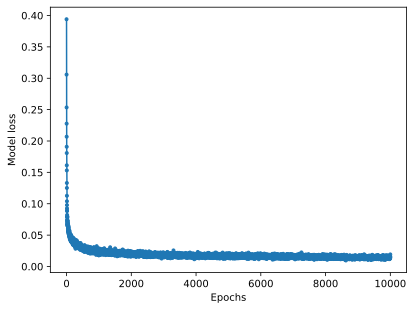

In [25]:
# train the model
losses, net = function2trainTheModel()
print(f"Final loss: {losses[-1]:.4f}")

# visualize the losses
plt.plot(losses.cpu(), ".-")
plt.xlabel("Epochs")
plt.ylabel("Model loss")
plt.show()

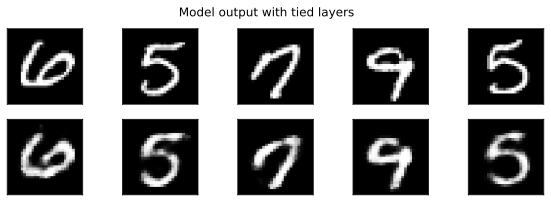

In [26]:
# Visualization of inputs and outputs
X = dataT[:5, :]
yHat = net(X)


# let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(X[i, :].view(28, 28).detach().cpu(), cmap="gray")
    axs[1, i].imshow(yHat[i, :].view(28, 28).detach().cpu(), cmap="gray")
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.suptitle("Model output with tied layers")
plt.show()